## LAB Assignment
Please finish the **Exercise** and answer **Questions**.
### Exercise (100 Points)
In this lab, our goal is to write a program to segment different objects using the **GMM and EM** algorithm. We also use <u>*k-means* clustering algorithm to initialize the parameters</u> of GMM. The following steps should be implemented to achieve such a goal:

1. Load image
2. Initialize parameters of GMM using K-means
3. Implement the EM algorithm for GMM
4. Display result

#### Import some libraries

In [1]:
# Dependency
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import tqdm

from PIL import Image

COLORS = [
    (255, 0, 0),   # red
    (0, 255, 0),  # green
    (0, 0, 255),   # blue
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
]



In [9]:
# import torch as np
# np.array = np.Tensor
# np.ndarray = np.TensorType
# np.array.astype = np.array.to
# np.asarray = lambda x:  np.asarray([item.cpu().detach().numpy() for item in x]).astype(np.float64)

#### Load Image
What you should do is to implement Z-score normalization in `load()`:

In [2]:
import cv2
def load(image_path):
    image = cv2.imread(image_path)
    image = np.asarray(image)
    h, w, c = image.shape

    # please normalize image_pixl using Z-score
    
    # Z-score = (x - mean) / std  没什么神奇的。
    image_norm = (image - np.mean(image, axis=(0, 1))) / np.std(image, axis=(0, 1))
    
    
    # 需要注意的是，x有三个维度，std要不要算协方差呢？ 其实是有必要的。我们试试效果。
    # X = [x1, x2, x3]T      y=AX => y = [a1, a2, a3] * [x1, x2, x3]T = a1*x1 + a2*x2 + a3*x3
    # Var(y) = A * Var(X) * A.T
    # 要让 Var(Z) = I  Z=AX, Var(X) = cov
    # 则 1 = A * cov * A.T，  已知A=A.T, 1 = A * cov * A，  A = cov**-0.5
    # 经过尝试，不行。因为A存在负数。 
    # cov = np.cov(image.reshape(-1, 3).T)  # 3x3矩阵
    # image_norm = np.einsum("ijk,kn->ijn", (image - np.mean(image, axis=(0, 1))), np.linalg.pinv(cov)**2)
    
    return h, w, c, image_norm.reshape(-1, 3)
a = load('data/original/sample.png')
a[3].shape

(187308, 3)

#### Initialize means, covariance matrices and mixing coefficients of GMM
k-means is used to initialize means, covariance matrices and mixing coefficients of GMM

In [3]:
def kmeans(n_cluster, image_pixl):
    kmeans = KMeans(n_clusters=n_cluster)# instantiate a K-means
    labels = kmeans.fit_predict(image_pixl)# fit and get clustering result
    initial_mus = kmeans.cluster_centers_# get centroids
    initial_priors, initial_covs = [], []
    #Followings are for initialization:
    for i in range(n_cluster):
        datas = image_pixl[labels == i, ...].T
        initial_covs.append(np.cov(datas))
        initial_priors.append(datas.shape[1] / len(labels))
    return initial_mus, initial_priors, initial_covs


#### Implement GMM algorithm
We use EM algorithm to refine GMM's parameters.

Although it may be not easy for some students to derive EM formula for GMM, GMM isn't very difficult to implement once you have the formula. Therefore, to help you understand GMM more, there are still some blanks for you to fill in.

<div  align="center"> <img src="images/EM-step.png"  /></div>

##### E-step
It is in `inference()`.

In the following code, `prob` is $\pi_k\mathcal{N}(\mathbf{x}_n|\pmb{\mu}_k,\pmb\Sigma_k)$, `gamma` is  $\gamma$. You need to implement log likelihood and $\gamma$.
```python
def inference(self, datas):
    probs = []
    for i in range(self.ncomp):
        mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
        prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov, allow_singular=True)
        probs.append(np.expand_dims(prob, -1))
    preds = np.concatenate(probs, axis=1)
    
    # TODO: calc log likelihood
    log_likelihood = None

    # TODO: calc gamma
    gamma = None

    return gamma, log_likelihood
```

##### M-step
It is in `update()`

You need to implement mean $\mu$, covariance $\Sigma$ and mixing coefficient $\pi$ .
```python
def update(self, datas, gamma):
    new_mus, new_covs, new_priors = [], [], []
    soft_counts = np.sum(gamma, axis=0)
    for i in range(self.ncomp):
        # TODO: calc mu
        new_mu = None
        new_mus.append(new_mu)

        # TODO: calc cov
        new_cov = None
        new_covs.append(new_cov)

        # TODO: calc mixing coefficients
        new_prior = None
        new_priors.append(new_prior)

    self.mus = np.asarray(new_mus)
    self.covs = np.asarray(new_covs)
    self.priors = np.asarray(new_priors)
```

#### Iteration
Iteration part is as you see in `fit()`
``` python
def fit(self, data, iteration):
    prev_log_liklihood = None

    bar = tqdm.tqdm(total=iteration)
    for i in range(iteration):
        gamma, log_likelihood = self.inference(data)
        self.update(data, gamma)
        if prev_log_liklihood is not None and abs(log_likelihood - prev_log_liklihood) < 1e-10:
            break
        prev_log_likelihood = log_likelihood

        bar.update()
        bar.set_postfix({"log likelihood": log_likelihood})
```

In [9]:
class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        """
        :param ncomp:           the number of clusters
        :param initial_mus:     initial means
        :param initial_covs:    initial covariance matrices
        :param initial_priors:  initial mixing coefficients
        """
        self.ncomp = ncomp # K 类别数
        
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas):
        """
        E-step
        E-step是假设参数已知，得到Z的概率分布，然后根据这个分布区预测X1:N和Z1:N出现的似然。
        同时我们还要求gamma，也就是Z的后验概率。这里的gamma是一个N*K的矩阵。
        
        :param datas:   original data
        :return:        posterior probability (gamma) and log likelihood
        """
        probs = []  
        for i in range(self.ncomp): # 遍历每个类别
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i] #这是上一轮的参数
            prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov, allow_singular=True) # 每个数据出现属于这一类的概率。
            # probs.append(prob.unsqueeze(-1)) # 变成列向量
            probs.append(np.expand_dims(prob, -1)) # 变成列向量
        preds = np.concatenate(probs, axis=1) # N * K 矩阵，表示每个数据属于每个类别的概率。

        # calc log likelihood。 我们算的似然是，在Z1:N|X1:N, theta 条件下， theta对X和Z的似然。
        # 计算似然的值的目的是为了判断算法是否收敛。因为我们的目标是最大化似然。
        log_likelihood = np.sum(np.log(np.sum(preds, axis=1)+1e-6)) # 里面对列求和，因为这是高斯混合模型的公式之一；外面求和是因为log把乘法变成了加法。

        # calc gamma
        gamma = preds / np.sum(preds, axis=1, keepdims=True)

        return gamma, log_likelihood

    def update(self, datas, gamma):
        """
        M-step
        M-step是假设Z已知, 这个时候X和Z都已知，可以对参数theta作极大似然估计。
        经过求导似然可以知道其实Z和X已知的时候很好办。
        :param datas:   original data
        :param gamma:    gamma
        :return:
        """
        new_mus, new_covs, new_priors = [], [], [] # K * M维, K * M * M维, K维
        soft_counts = np.sum(gamma, axis=0) # 1*K 每个类别的数据个数
        for i in range(self.ncomp): # 所有类别遍历一下
            # calc mu_i  根据求导得到的方程，一定是i类别数据的均值。注意我们数据的类别不是整数，是有一定的概率的。
            new_mu = np.einsum('ij, i -> j', datas, gamma[:, i]) / soft_counts[i] 
            new_mus.append(new_mu)

            # calc cov_i 其实就是数据的协方差。算法是 
            delta = datas - new_mu # N * M 维+
            # new_cov =  delta.T @ (np.diag(gamma[:, i]) @ delta) / soft_counts[i]
            # 上面这个运算虽然正确，但是中间的矩阵太大了，无法分配内存。
            # 实际上中间的矩阵不需要存在，可以for循环求和代替。
            # 这里我们使用更加优雅高效的 einsum 表示法表示这个计算。
            new_cov =  np.einsum(' ij,j,jk ->ik ', delta.T, gamma[:, i], delta) / soft_counts[i]
            new_covs.append(new_cov)

            # calc mixing coefficients
            new_prior = soft_counts[i] / np.sum(soft_counts) # 每个类别的概率
            new_priors.append(new_prior)

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)

    def fit(self, data, iteration):
        prev_log_liklihood = None

        bar = tqdm.tqdm(total=iteration)
        for i in range(iteration):
            gamma, log_likelihood = self.inference(data)
            self.update(data, gamma)
            if prev_log_liklihood is not None and abs(log_likelihood - prev_log_liklihood) < 1e-10:
                break
            prev_log_likelihood = log_likelihood

            bar.update()
            bar.set_postfix({"log likelihood": log_likelihood})

#### Display
We use `matplotlib` to display what we segment, you can check the code in `visualize()`

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


def visualize(gmm, image, ncomp, ih, iw):
    beliefs, log_likelihood = gmm.inference(image)
    map_beliefs = np.reshape(beliefs, (ih, iw, ncomp))
    segmented_map = np.zeros((ih, iw, 3))
    for i in range(ih):
        for j in range(iw):
            hard_belief = np.argmax(map_beliefs[i, j, :])
            segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
    return segmented_map

In [10]:
ih, iw, ic, image_norm = load("data/original/sample.png")
ncomp = 3
iteration=500
# init mu, prior and cov
initial_mus, initial_priors, initial_covs = kmeans(ncomp, image_norm)

# GMM
print("GMM begins...")
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)
gmm.fit(image_norm, iteration)

GMM begins...



























































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 500/500 [00:47<00:00, 10.60it/s, log likelihood=2.22e+5]


  0%|          | 0/500 [01:47<?, ?it/s]


Finish!


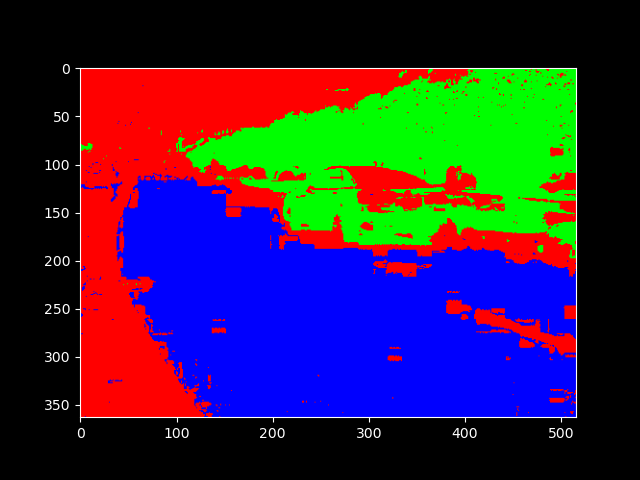

In [13]:
# visualize
%matplotlib widget
import numpy as np
image = visualize(gmm, image_norm, ncomp, ih, iw)
print("Finish!")
plt.imshow(image)

In [14]:
cv2.imshow("image", image)
cv2.waitKey(0)

-1

### Questions(3 points)
1. What are the strengths of GMM; when does it perform well?

- 当数据服从高斯混合分布时，GMM表现良好。因为GMM是生成模型，生成方式的假设就是数据服从高斯混合分布，所以GMM的表现就取决于数据是否服从高斯混合分布。
- Kmeans是GMM的一个特例。GMM允许簇的形状不是圆形，而Kmeans只允许簇的形状是圆形。
- GMM允许椭圆，这就可以解决上面的两个 交叉的流形 的问题，可以变成多个椭圆的组合。

![image](https://pic3.zhimg.com/80/v2-aa10483f3cfe0582baffb935471b70ba_1440w.webp)

2. What are the weaknesses of GMM; when does it perform poorly?

- 当数据不服从高斯混合分布时，GMM表现不佳。
- 如果EM算法的近似不够准确，那么GMM的参数估计也不够准确。


3. What makes GMM a good candidate for the clustering problem, if you have enough knowledge about the data?

- 如果我们知道数据服从高斯混合分布，那么GMM就是一个很好的选择。